# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [3]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design


In [4]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

ModuleNotFoundError: No module named 'mamba_ssm'

In [ ]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [ ]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [ ]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [ ]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

In [ ]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [ ]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [512, 1024],
                 out_channels = 128,
                 last_known_loc = 2)

In [ ]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 60 )

Epoch [1/60], Loss: 0.006196817950112745
Epoch [2/60], Loss: 0.002518112649559043
Epoch [3/60], Loss: 0.0020003128371899946
Epoch [4/60], Loss: 0.0015766454284312204
Epoch [5/60], Loss: 0.0011833806842332707
Epoch [6/60], Loss: 0.0009111770102754235
Epoch [7/60], Loss: 0.0005868951004231349
Epoch [8/60], Loss: 0.0003636670237756334
Epoch [9/60], Loss: 0.00020590121428540442
Epoch [10/60], Loss: 0.0001328737710355199
Epoch [11/60], Loss: 8.032480049223523e-05
Epoch [12/60], Loss: 4.792954508957337e-05
Epoch [13/60], Loss: 4.949198664689902e-05
Epoch [14/60], Loss: 4.351509584012092e-05
Epoch [15/60], Loss: 3.7342196674217123e-05
Epoch [16/60], Loss: 4.1132087289952324e-05
Epoch [17/60], Loss: 4.8815578757057666e-05
Epoch [18/60], Loss: 7.414561585392221e-05
Epoch [19/60], Loss: 0.0006411607441259549
Epoch [20/60], Loss: 0.00030570292507036355
Epoch [21/60], Loss: 5.3397228512039874e-05
Epoch [22/60], Loss: 1.979339935587632e-05
Epoch [23/60], Loss: 1.5918729186523706e-05
Epoch [24/60], 

## CerberusTS Training (No Foresight)

In [ ]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 last_known_loc= 2 )
                 

In [ ]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.00044689990907500034
Epoch [2/100], Loss: 0.0003519466528086923
Epoch [3/100], Loss: 0.000320539543099585
Epoch [4/100], Loss: 0.00029636574545293114
Epoch [5/100], Loss: 0.00027871762809809295
Epoch [6/100], Loss: 0.00026243873762723526
Epoch [7/100], Loss: 0.00025160167147987523
Epoch [8/100], Loss: 0.00023228127167385538
Epoch [9/100], Loss: 0.0002174214824481169
Epoch [10/100], Loss: 0.00020806523505598307
Epoch [11/100], Loss: 0.0001937056837778073
Epoch [12/100], Loss: 0.00018483625979570206
Epoch [13/100], Loss: 0.00017702494405966718
Epoch [14/100], Loss: 0.00016473043087898985
Epoch [15/100], Loss: 0.00015477265700610587
Epoch [16/100], Loss: 0.00014413644075830234
Epoch [17/100], Loss: 0.00015874295888352208
Epoch [18/100], Loss: 0.00013514927348296624
Epoch [19/100], Loss: 0.0001223984074385953
Epoch [20/100], Loss: 0.00010972783489705762
Epoch [21/100], Loss: 0.00010598048163956264
Epoch [22/100], Loss: 0.00010750188634119696
Epoch [23/100], Loss: 0.0

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [ ]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 last_known_loc = 2)

In [ ]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.0003624398322426714
Epoch [2/100], Loss: 0.0002568157829955453
Epoch [3/100], Loss: 0.0001885399522871012
Epoch [4/100], Loss: 0.00014683953126223059
Epoch [5/100], Loss: 0.00011554970082215732
Epoch [6/100], Loss: 9.463645594223635e-05
Epoch [7/100], Loss: 8.200258742363075e-05
Epoch [8/100], Loss: 7.129853885999182e-05
Epoch [9/100], Loss: 6.281037953158375e-05
Epoch [10/100], Loss: 5.6385811149084475e-05
Epoch [11/100], Loss: 5.124112361954758e-05
Epoch [12/100], Loss: 4.498727434111061e-05
Epoch [13/100], Loss: 4.0525414333387745e-05
Epoch [14/100], Loss: 3.997120353233186e-05
Epoch [15/100], Loss: 3.509908285195706e-05
Epoch [16/100], Loss: 3.377454048859363e-05
Epoch [17/100], Loss: 2.987455746733758e-05
Epoch [18/100], Loss: 2.938023213573615e-05
Epoch [19/100], Loss: 2.54950362159434e-05
Epoch [20/100], Loss: 2.3861370441409234e-05
Epoch [21/100], Loss: 2.0043866397827516e-05
Epoch [22/100], Loss: 1.7030491362675094e-05
Epoch [23/100], Loss: 2.02892756533

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

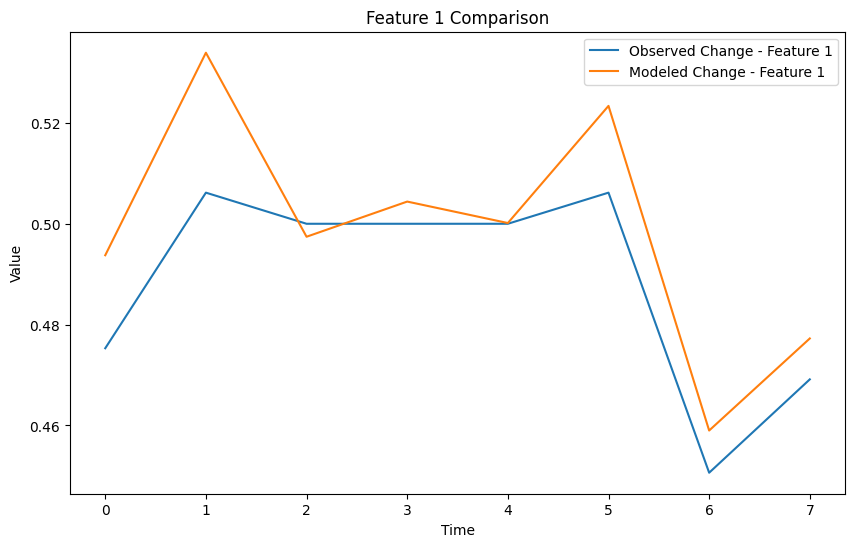

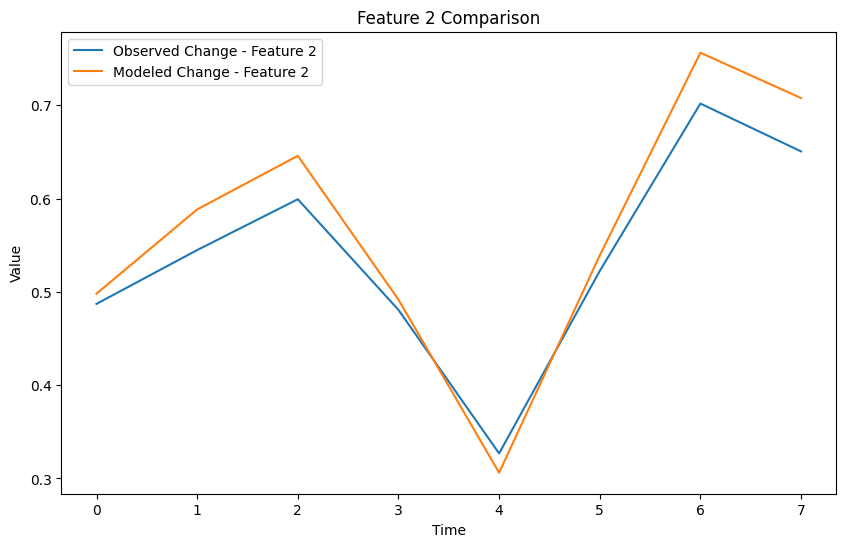

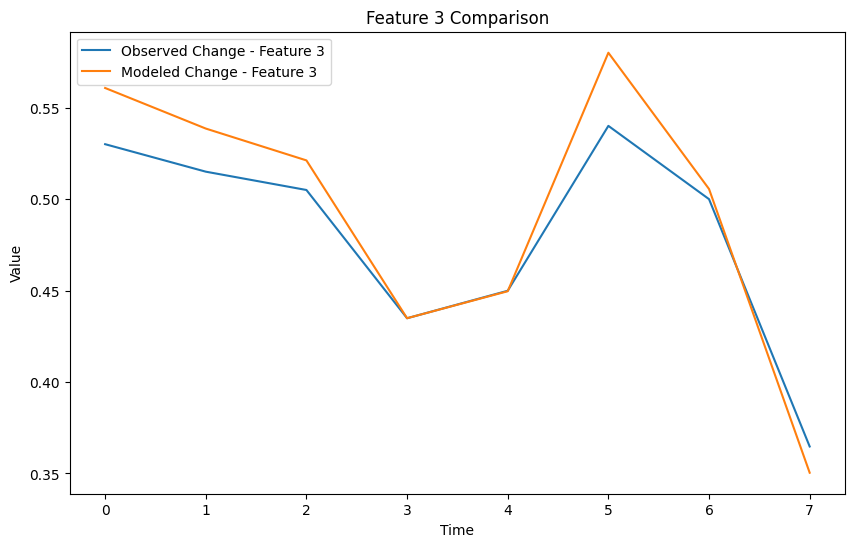

In [ ]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

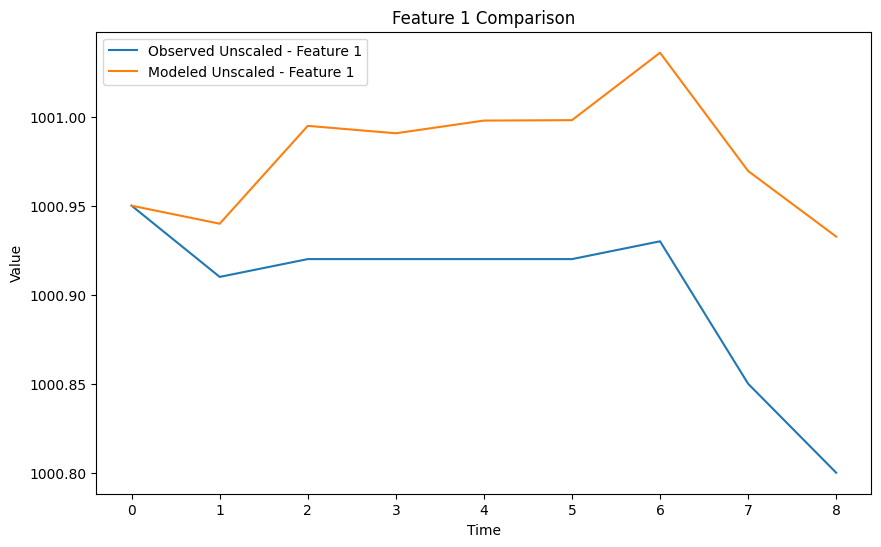

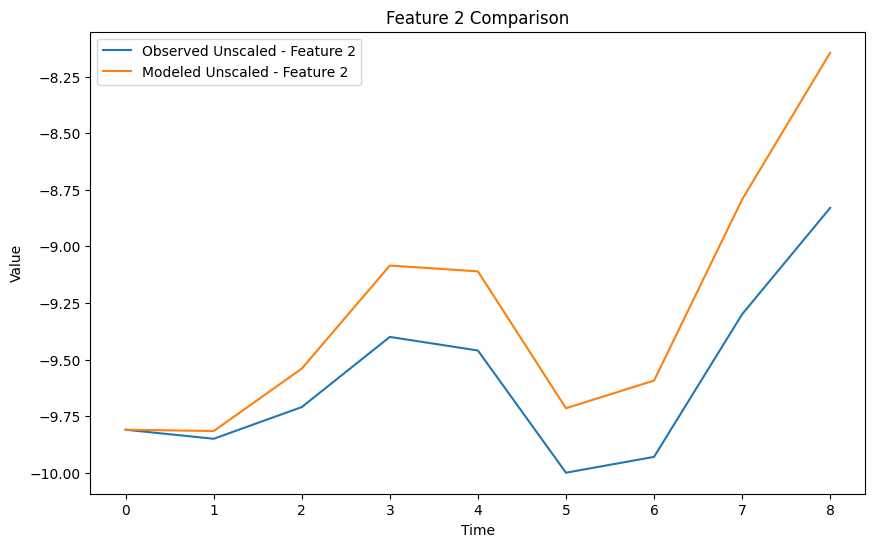

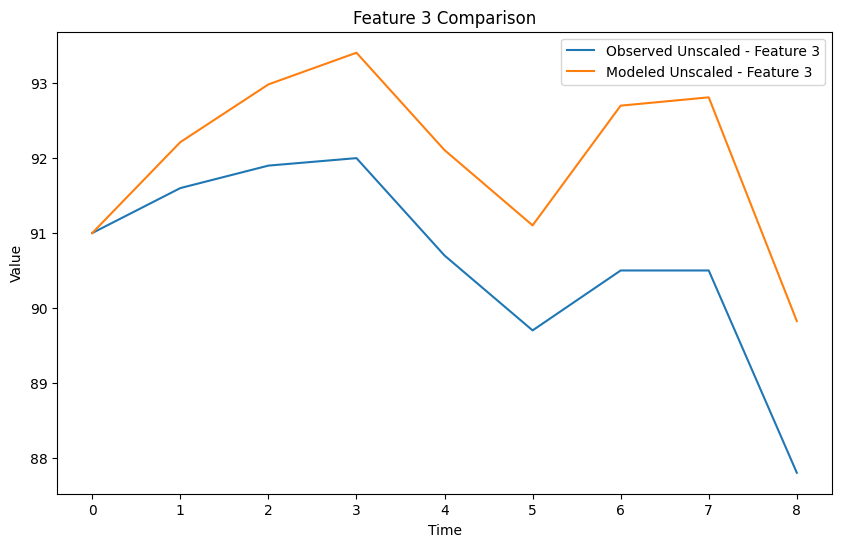

In [ ]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)

In [ ]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cerberus_foresight)

18052355